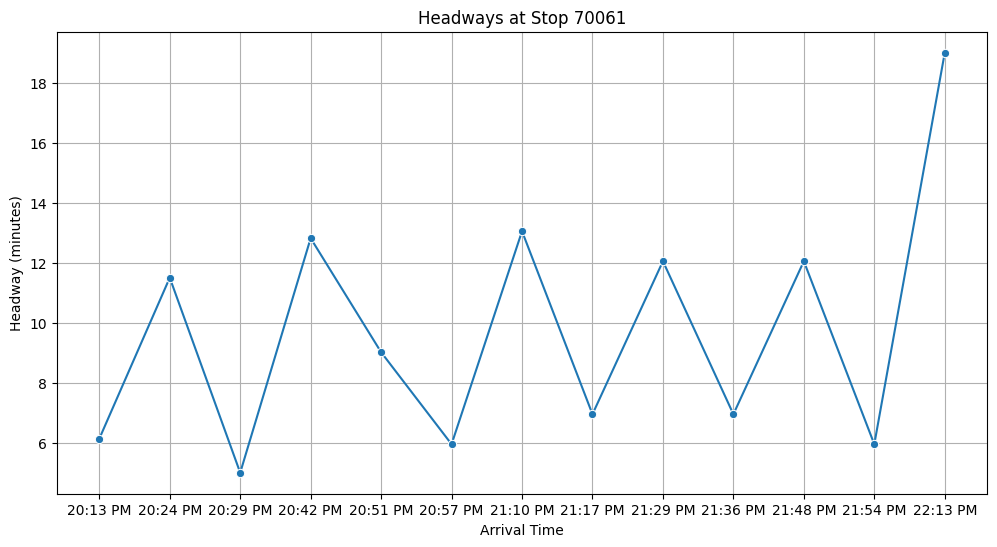

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from google.transit import gtfs_realtime_pb2
from datetime import datetime, timedelta
import pytz 

eastern = pytz.timezone('US/Eastern')
feed_url = "https://cdn.mbta.com/realtime/TripUpdates.pb"
response = requests.get(feed_url)
feed = gtfs_realtime_pb2.FeedMessage()
feed.ParseFromString(response.content)

data = []
for entity in feed.entity:
    if entity.HasField('trip_update'):
        for stop_time_update in entity.trip_update.stop_time_update:
            data.append({
                'trip_id': entity.trip_update.trip.trip_id,
                'stop_id': stop_time_update.stop_id,
                'arrival_time': stop_time_update.arrival.time,
                'departure_time': stop_time_update.departure.time
            })

df = pd.DataFrame(data)

df['arrival_time'] = pd.to_datetime(df['arrival_time'], unit='s', errors='coerce').dt.tz_localize('UTC').dt.tz_convert(eastern)
df['departure_time'] = pd.to_datetime(df['departure_time'], unit='s', errors='coerce').dt.tz_localize('UTC').dt.tz_convert(eastern)

df.dropna(subset=['arrival_time', 'departure_time'], inplace=True)

current_time = datetime.now(pytz.utc).astimezone(eastern)
min_time = current_time - timedelta(weeks=1)
max_time = current_time


stop_id_to_filter = '70061'
df_filtered = df[
    (df["arrival_time"] >= min_time)
    # & (df["arrival_time"] <= max_time)
    & (df["stop_id"] == stop_id_to_filter)
]

df_filtered = df_filtered.sort_values(by='arrival_time', inplace=False)

df_filtered['headway'] = df_filtered['arrival_time'].diff().dt.total_seconds() / 60  # headway in minutes

df_filtered = df_filtered.dropna(subset=['headway'], inplace=False)

df_filtered['arrival_time_only'] = df_filtered['arrival_time'].dt.strftime('%H:%M %p')

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_filtered, x='arrival_time_only', y='headway', marker='o')

plt.title("Headways at Stop 70061")
plt.xlabel('Arrival Time')
plt.ylabel('Headway (minutes)')
plt.grid(True)
plt.show()


In [ ]:
routes = pd.read_csv("data/MBTA_GTFS/routes.txt")
print(routes.head())